In [1]:
import pandas as pd
from sklearn.preprocessing import normalize
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from lightgbm.sklearn import LGBMRegressor
from sklearn.compose import make_column_transformer

In [2]:
from sklearn.metrics import mean_squared_error
def exceptOneValidation(model,X,y,period=5000):
    score=[]
    predict=[]
    error=[]
    for i in range(0,len(X),period):
        if i==0:
            X_train=X.iloc[period:,:]
            y_train=y.iloc[period:]
            X_test=X.iloc[0:period,:]
            y_test=y.iloc[0:period]
        elif i==len(X)-period:
            X_train=X.iloc[0:i,:]
            y_train=y.iloc[0:i]
            X_test=X.iloc[i:i+period,:]
            y_test=y.iloc[i:i+period]
        else:
            X_train=pd.concat([X.iloc[0:i,:],X.iloc[i+period:,:]],axis=0)
            y_train=pd.concat([y.iloc[0:i],y.iloc[i+period:]],axis=0)
            X_test=X.iloc[i:i+period,:]
            y_test=y.iloc[i:i+period]
        model.fit(X_train,y_train)
        y_pred=model.predict(X_test)
        predict=np.concatenate([predict,y_pred])
        score.append(model.score(X_test,y_test))
        error.append(mean_squared_error(y_test,y_pred))
    return score,error,predict

In [3]:
data=pd.read_csv("data/data_filtrage_5.csv")

In [4]:
df=data.copy()

In [5]:
def get_variation(df):
    
    x_lum_var=df.x_lumbar-df.x_lumbar.shift(periods=1, fill_value=df.x_lumbar[len(df)-1])
    y_lum_var=df.y_lumbar-df.y_lumbar.shift(periods=1, fill_value=df.y_lumbar[len(df)-1])
    z_lum_var=df.z_lumbar-df.z_lumbar.shift(periods=1, fill_value=df.z_lumbar[len(df)-1])
    x_tib_var=df.x_tibia-df.x_tibia.shift(periods=1, fill_value=df.x_tibia[len(df)-1])
    y_tib_var=df.y_tibia-df.y_tibia.shift(periods=1, fill_value=df.y_tibia[len(df)-1])
    z_tib_var=df.z_tibia-df.z_tibia.shift(periods=1, fill_value=df.z_tibia[len(df)-1])

    df_var= pd.DataFrame(
    {'var_x_lumbar': x_lum_var,
     'var_y_lumbar': y_lum_var,
     'var_z_lumbar': z_lum_var,
     'var_x_tibia': x_tib_var,
     'var_y_tibia': y_tib_var,
     'var_z_tibia': z_tib_var
    })
    
    return df.join(df_var)

In [6]:
df=get_variation(df)
X=df.drop(['index','nb_seance','nb_passage','x_force','z_force','y_force'],axis=1)
y=df['z_force']

In [7]:
lgbmr=LGBMRegressor(boosting_type='goss',random_state=42,n_estimators=300,learning_rate=0.2,n_jobs=-1)
score_lgbmr,error_lgbmr,predict_lgbmr=exceptOneValidation(lgbmr,X,y)

In [8]:
pd.Series(error_lgbmr).describe()

count      100.000000
mean      2468.875895
std       3372.676300
min        248.328251
25%       1177.314163
50%       1694.503792
75%       2524.504441
max      27098.788083
dtype: float64

In [9]:
pd.Series(score_lgbmr).describe()

count    100.000000
mean       0.990682
std        0.012552
min        0.903326
25%        0.990424
50%        0.993388
75%        0.995712
max        0.999100
dtype: float64

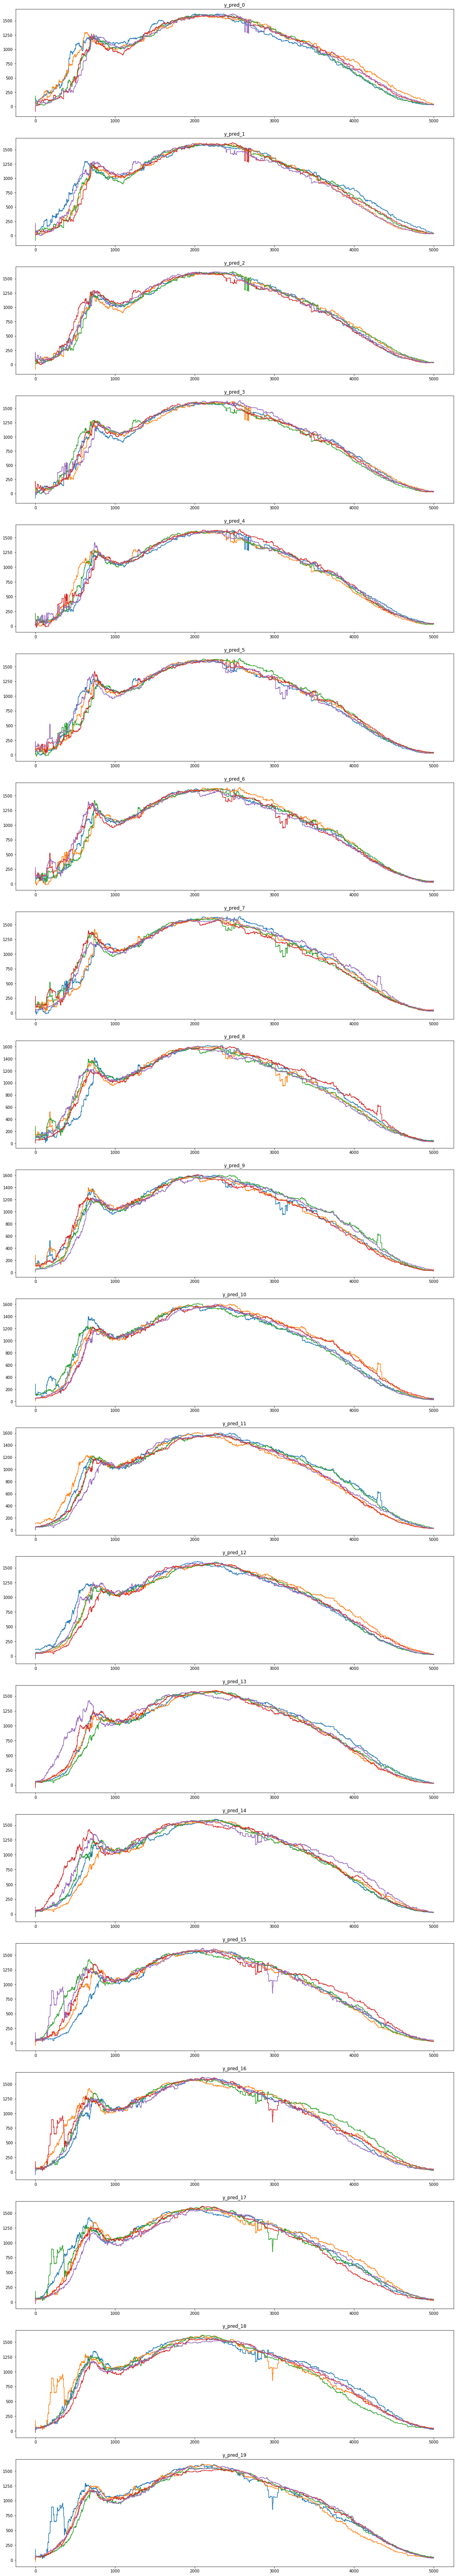

In [12]:
df['z_pred']=predict_lgbmr
fig,axes = plt.subplots(20,1,figsize=(20,120))
for i in range(20):
    df['z_pred'].iloc[i*5000:i*5000+5000].reset_index(drop=True).plot(ax=axes[i],title=f'z_pred_{i}')
    df['z_pred'].iloc[(i+1)*5000:(i+1)*5000+5000].reset_index(drop=True).plot(ax=axes[i],title=f'z_pred_{i}')
    df['z_pred'].iloc[(i+2)*5000:(i+2)*5000+5000].reset_index(drop=True).plot(ax=axes[i],title=f'z_pred_{i}')
    df['z_pred'].iloc[(i+3)*5000:(i+3)*5000+5000].reset_index(drop=True).plot(ax=axes[i],title=f'z_pred_{i}')
    df['z_pred'].iloc[(i+4)*5000:(i+4)*5000+5000].reset_index(drop=True).plot(ax=axes[i],title=f'z_pred_{i}')

In [13]:
df['z_pred_smooth']=df['z_pred']
wind=201
windna=int((wind-1)/2)
for i in range(100):
    df['z_pred_smooth'].iloc[i*5000+windna:i*5000+5000-windna]=df['z_pred'].iloc[i*5000:i*5000+5000].rolling(wind,center=True).mean().iloc[windna:-windna]

/tmp/ipykernel_5556/45787381.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['y_pred_smooth'].iloc[i*5000+windna:i*5000+5000-windna]=df['y_pred'].iloc[i*5000:i*5000+5000].rolling(wind,center=True).mean().iloc[windna:-windna]


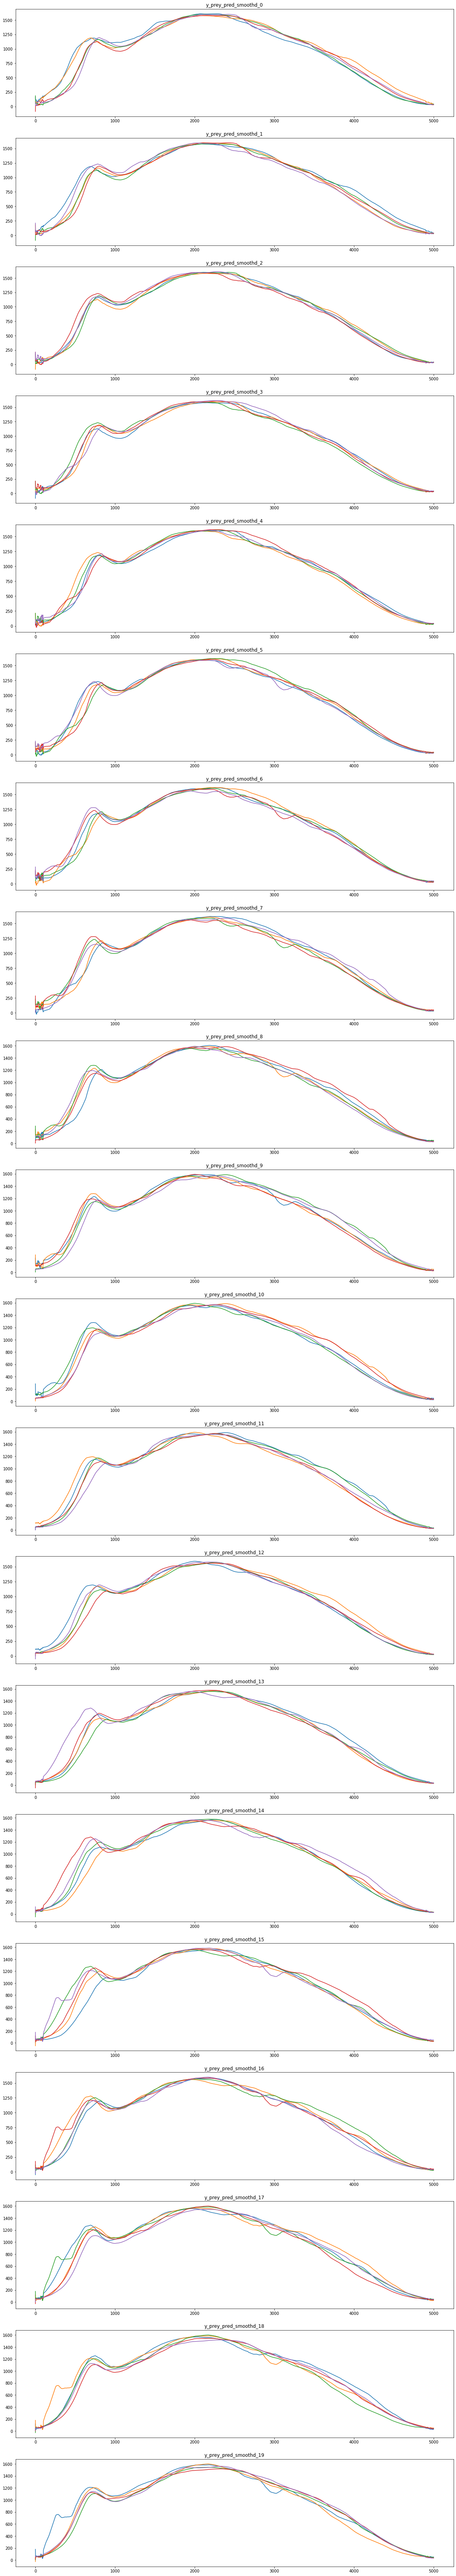

In [14]:
fig,axes = plt.subplots(20,1,figsize=(20,120))
for i in range(20):
    df['z_pred_smooth'].iloc[i*5000:i*5000+5000].reset_index(drop=True).plot(ax=axes[i],title=f'z_pred_{i}')
    df['z_pred_smooth'].iloc[(i+1)*5000:(i+1)*5000+5000].reset_index(drop=True).plot(ax=axes[i],title=f'z_pred_{i}')
    df['z_pred_smooth'].iloc[(i+2)*5000:(i+2)*5000+5000].reset_index(drop=True).plot(ax=axes[i],title=f'z_pred_{i}')
    df['z_pred_smooth'].iloc[(i+3)*5000:(i+3)*5000+5000].reset_index(drop=True).plot(ax=axes[i],title=f'z_pred_{i}')
    df['z_pred_smooth'].iloc[(i+4)*5000:(i+4)*5000+5000].reset_index(drop=True).plot(ax=axes[i],title=f'z_prey_pred_smoothd_{i}')

In [15]:
from sklearn.metrics import mean_squared_error, r2_score
print(mean_squared_error(df['z_force'],df['z_pred'])**(1/2),mean_squared_error(df['z_force'],df['y_pred_smooth'])**(1/2))
print(r2_score(df['z_force'],df['z_pred']),r2_score(df['z_force'],df['z_pred_smooth']))

49.68778416017293 44.97667953461046
0.9906906408364281 0.9923722700941757
